In [1]:
%matplotlib inline

import numpy as np
from pprint import pprint

from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import torchvision
from torchvision import models, datasets, transforms

torch.manual_seed(50)

print(torch.__version__, torchvision.__version__)

1.7.1+cu110 0.8.2+cu110


In [2]:
# 加载CIFAR-10数据集，如果本地没有则自动下载
dst = datasets.CIFAR10("/home/raoxy/data", download=True)

# 定义一个转换序列，包括缩放、裁剪、转换为张量等操作
tp = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor()
])

# 定义一个函数，用于将张量转换为PIL图像
tt = transforms.ToPILImage()

# 检测是否有可用的GPU，如果有则使用GPU，否则使用CPU
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
print("Running on %s" % device)

Files already downloaded and verified
Running on cuda


In [3]:
# 定义一个函数，用于将标签转换为one-hot编码的张量
def label_to_onehot(target, num_classes=10):
    # 在第一个维度上增加一个维度，使得target的形状为(N, 1)
    target = torch.unsqueeze(target, 1)
    # 创建一个全零的张量，形状为(N, num_classes)，设备与target相同
    onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
    # 在第二个维度上根据target的值将onehot_target的对应位置设为1
    onehot_target.scatter_(1, target, 1)
    # 返回onehot_target
    return onehot_target

# 定义一个函数，用于计算one-hot编码的标签和预测值之间的交叉熵损失
def cross_entropy_for_onehot(pred, target):
    # 对预测值进行log_softmax操作，然后与目标值相乘，再求和，最后求平均
    return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=-1), 1))

# LeNet

In [4]:
# 定义一个类，继承自nn.Module，表示LeNet模型
class LeNet(nn.Module):
    # 定义模型的构造函数
    def __init__(self):
        # 调用父类的构造函数
        super(LeNet, self).__init__()
        # 定义激活函数为Sigmoid
        act = nn.Sigmoid
        # 定义模型的卷积部分，包括四个卷积层和两个池化层，以及Sigmoid激活函数
        self.body = nn.Sequential(
            # 第一个卷积层，输入通道为3，输出通道为12，卷积核大小为5，填充为2，步长为2
            nn.Conv2d(3, 12, kernel_size=5, padding=5//2, stride=2),
            # 第一个激活层，使用Sigmoid函数
            act(),
            # 第二个卷积层，输入通道为12，输出通道为12，卷积核大小为5，填充为2，步长为2
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
            # 第二个激活层，使用Sigmoid函数
            act(),
            # 第三个卷积层，输入通道为12，输出通道为12，卷积核大小为5，填充为2，步长为1
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            # 第三个激活层，使用Sigmoid函数
            act(),
            # 第四个卷积层，输入通道为12，输出通道为12，卷积核大小为5，填充为2，步长为1
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            # 第四个激活层，使用Sigmoid函数
            act(),
        )
        # 定义模型的全连接部分，包括一个线性层
        self.fc = nn.Sequential(
            # 第一个线性层，输入特征为768，输出特征为10，表示10个类别
            nn.Linear(768, 10),
            # 注释掉了第二个激活层和第二个线性层，可能是为了简化模型
            #act(),
            #nn.Linear(256, 10)
        )
        
    # 定义模型的前向传播函数
    def forward(self, x):
        # 将输入数据通过卷积部分，得到输出
        out = self.body(x)
        # 将输出展平为一维向量，形状为(N, 768)，其中N是批量大小
        feature = out.view(out.size(0), -1)
        # 打印特征的形状，用于调试
        #print(feature.size())
        # 将特征通过全连接部分，得到最终的输出
        out = self.fc(feature)
        # 返回输出和特征
        return out, feature
    
# 创建一个LeNet模型的实例，并将其移动到设备上，可以是CPU或GPU
net = LeNet().to(device)
net

LeNet(
  (body): Sequential(
    (0): Conv2d(3, 12, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): Sigmoid()
    (2): Conv2d(12, 12, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (3): Sigmoid()
    (4): Conv2d(12, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): Sigmoid()
    (6): Conv2d(12, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (7): Sigmoid()
  )
  (fc): Sequential(
    (0): Linear(in_features=768, out_features=10, bias=True)
  )
)

In [5]:
# 定义一个函数，用于初始化模型的权重和偏置
def weights_init(m):
    # 如果模型有权重属性，就将其均匀分布在[-0.5, 0.5]之间
    if hasattr(m, "weight"):
        m.weight.data.uniform_(-0.5, 0.5)
    # 如果模型有偏置属性，也将其均匀分布在[-0.5, 0.5]之间
    if hasattr(m, "bias"):
        m.bias.data.uniform_(-0.5, 0.5)
        
    
# 调用weights_init函数，对模型的参数进行初始化
net.apply(weights_init)
# 定义损失函数为one-hot编码的交叉熵损失
criterion = cross_entropy_for_onehot

# 图像索引

In [6]:
# 定义一个图像索引，表示要显示的图像在数据集中的位置
img_index = 7

In [13]:
# KSVD
def K_Soteria(img_index):
    from PIL import Image
    import matplotlib.pyplot as plt

    gt_data = dst[img_index][0] # 从数据集中获取图像，并使用之前定义的转换序列处理图像
    img_array = np.array(gt_data)

    # 分离三个颜色通道
    R = img_array[:, :, 0]
    G = img_array[:, :, 1]
    B = img_array[:, :, 2]

    # 定义一个函数，用SVD对单通道矩阵进行压缩
    def compress_channel(data, k):
        from  ksvd import ApproximateKSVD
        ksvd = ApproximateKSVD(n_components=k)
        data = data.astype(np.float32)  # 将 data 转换为 float32 类型
        output_data =np.zeros_like(data)
        output_D = ksvd.fit(data).components_
        output_L = ksvd.transform(data)
        output_data =output_L.dot(output_D)
        return output_data

    k=33
    # 对每个颜色通道进行压缩
    R_k = compress_channel(R, k)
    G_k = compress_channel(G, k)
    B_k = compress_channel(B, k)
    # 将压缩后的三个颜色通道合并为一个三维数组
    img_array_k = np.stack((R_k, G_k, B_k), axis=2)
    # 将压缩后的数组转换为图片
    img_k = Image.fromarray(img_array_k.astype('uint8'))

    # 从数据集中获取图像，并使用之前定义的转换序列处理图像
    gt_data = tp(img_k).to(device)

    # 将图像的形状调整为(1, 3, 32, 32)，表示批量大小为1，通道数为3，高度和宽度为32
    gt_data = gt_data.view(1, *gt_data.size())
    # 从数据集中获取图像的标签，并转换为长整型张量
    gt_label = torch.Tensor([dst[img_index][1]]).long().to(device)
    # 将标签的形状调整为(1,)，表示批量大小为1
    gt_label = gt_label.view(1, )
    # 将标签转换为one-hot编码的张量，形状为(1, 10)，表示批量大小为1，类别数为10
    gt_onehot_label = label_to_onehot(gt_label, num_classes=10)
    # 设置图像的梯度属性为True，表示可以对图像进行梯度计算
    gt_data.requires_grad = True

    # 计算输出和特征向量相对于输入的导数的范数与特征向量的范数的比值，即||dr/dX||/||r||
    out,feature_fc1_graph = net(gt_data) # 通过网络得到输出和特征向量
    deviation_f1_target = torch.zeros_like(feature_fc1_graph) # 创建一个全零的张量，用于存储目标梯度
    deviation_f1_x_norm = torch.zeros_like(feature_fc1_graph) # 创建一个全零的张量，用于存储导数的范数
    for f in range(deviation_f1_x_norm.size(1)): # 对于每个特征向量的维度
        deviation_f1_target[:,f] = 1 # 将目标梯度的对应位置设为1
        feature_fc1_graph.backward(deviation_f1_target, retain_graph=True) # 对特征向量进行反向传播，计算梯度
        deviation_f1_x = gt_data.grad.data # 获取输入的梯度
        deviation_f1_x_norm[:,f] = torch.norm(deviation_f1_x.view(deviation_f1_x.size(0), -1), dim=1)/(feature_fc1_graph.data[:,f]) # 计算梯度的范数与特征向量的比值
        net.zero_grad() # 清零网络的梯度
        gt_data.grad.data.zero_() # 清零输入的梯度
        deviation_f1_target[:,f] = 0 # 将目标梯度的对应位置设为0

    # 根据最小的||dr_i/dX||/||r_i||来剪枝特征向量
    deviation_f1_x_norm_sum = deviation_f1_x_norm.sum(axis=0) # 对每个维度求和
    thresh = np.percentile(deviation_f1_x_norm_sum.flatten().cpu().numpy(), 1) # 根据百分位数确定阈值
    mask = np.where(abs(deviation_f1_x_norm_sum.cpu()) < thresh, 0, 1).astype(np.float32) # 根据阈值生成掩码，小于阈值的为0，大于阈值的为1
    y = criterion(out, gt_onehot_label) # 计算输出和标签之间的损失
    dy_dx = torch.autograd.grad(y, net.parameters()) # 计算损失对网络参数的梯度

    # 与其他客户端共享梯度
    original_dy_dx = list((_.detach().clone() for _ in dy_dx)) # 复制梯度
    original_dy_dx[-2] = original_dy_dx[-2] * torch.Tensor(mask).to(device)# 将梯度乘以掩码，实现剪枝

    # 生成一些随机的数据和标签，形状与真实的数据和标签相同
    dummy_data_init = torch.randn(gt_data.size()) # 使用torch.randn()函数[^1^][1]生成一个服从标准正态分布的张量
    dummy_label_init = torch.randn(gt_onehot_label.size()) # 同上

    # 将随机的数据和标签转换为张量，并移动到设备上，可以是CPU或GPU
    dummy_data = torch.Tensor(dummy_data_init).to(device).requires_grad_(True) # 使用torch.Tensor()函数将numpy数组转换为张量，并设置requires_grad属性为True，表示可以对数据进行梯度计算
    dummy_label = torch.Tensor(dummy_label_init).to(device).requires_grad_(True) # 同上

    # 定义一个LBFGS优化器，将虚拟的数据和标签作为需要优化的参数
    optimizer = torch.optim.LBFGS([dummy_data, dummy_label] )
    # 注释掉了另一个优化器，SGD，可能是为了比较效果
    #optimizer = torch.optim.SGD([dummy_data, dummy_label], lr=0.1, momentum=0.9 )

    # 创建一个空列表，用于存储优化过程中的虚拟数据
    history = []
    # 定义一个变量，用于存储虚拟数据和真实数据之间的最小均方误差
    MSE_min = 100
    # 进行300次迭代优化
    for iters in range(300):
        # 定义一个闭包函数，用于计算虚拟数据和标签的梯度差
        def closure():
            # 清零优化器的梯度
            optimizer.zero_grad()
            # 通过网络得到虚拟数据的预测和特征向量
            #out, [feature_fc1_graph, feature_fc2_graph, feature_fc3_graph] = net(gt_data)
            pred, f1 = net(dummy_data) 
            # 对虚拟标签进行softmax操作，得到one-hot编码的张量
            dummy_onehot_label = F.softmax(dummy_label, dim=-1)
            # 计算预测和虚拟标签之间的损失，使用之前定义的交叉熵损失函数
            dummy_loss = criterion(pred, dummy_onehot_label) # TODO: fix the gt_label to dummy_label in both code and slides.
            # 计算损失对网络参数的梯度，创建计算图
            dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)

            # 初始化梯度差和梯度数量为0
            grad_diff = 0
            grad_count = 0


            i = 0
            for gx, gy in zip(dummy_dy_dx, original_dy_dx): # TODO: fix the variablas here
                # 只计算前100个参数的梯度差，可能是为了节省计算资源
                if i <=100:
                    grad_diff += ((gx - gy) ** 2).sum()
                    grad_count += gx.nelement()
                i += 1
            # 计算梯度差的平均值，乘以一个系数，可能是为了调整梯度的大小
            #grad_diff = grad_diff / grad_count * 1000

            # 计算特征向量和真实数据的差的平方和，可能是另一种计算梯度差的方法
            #grad_diff = ((feature_fc1_graph - f1) ** 2).sum()
            # 对梯度差进行反向传播，计算虚拟数据和标签的梯度
            grad_diff.backward()

            # 返回梯度差
            return grad_diff

        # 调用优化器的step()方法，使用闭包函数进行一步优化
        optimizer.step(closure)
        # 如果当前的均方误差小于之前的最小值，就更新最小值
        if MSE_min > (gt_data[0] - dummy_data[0]).pow(2).mean().item():
            MSE_min = (gt_data[0] - dummy_data[0]).pow(2).mean().item()
        # 每隔10次迭代，打印当前的迭代次数，梯度差，均方误差和最小均方误差
        if iters % 10 == 0: 
            current_loss = closure()
            print("{}, loss: {}, MSE: {}, MSE_min: {}".format(iters, current_loss.item(), (gt_data[0] - dummy_data[0]).pow(2).mean().item(), MSE_min))
        # 将当前的虚拟数据添加到历史列表中
        history.append(tt(dummy_data[0].cpu()))
    return history

History=[]

for i in range(50):
    History.append(K_Soteria(i)[-1])
    print("#"*50+"["+ str(i)+"]"+"#"*50)

0, loss: 30.292503356933594, MSE: 1.156386137008667, MSE_min: 1.156386137008667
10, loss: 15.699116706848145, MSE: 0.404045045375824, MSE_min: 0.404045045375824
20, loss: 15.350750923156738, MSE: 0.11979701370000839, MSE_min: 0.11979701370000839
30, loss: 15.32148551940918, MSE: 0.04588552936911583, MSE_min: 0.04588552936911583
40, loss: 15.317214012145996, MSE: 0.024301715195178986, MSE_min: 0.024301715195178986
50, loss: 15.316123962402344, MSE: 0.01805628463625908, MSE_min: 0.01805628463625908
60, loss: 15.315911293029785, MSE: 0.01672440394759178, MSE_min: 0.01672440394759178
70, loss: 15.315811157226562, MSE: 0.01594211906194687, MSE_min: 0.01594211906194687
80, loss: 15.31572151184082, MSE: 0.015197357162833214, MSE_min: 0.015197357162833214
90, loss: 15.315692901611328, MSE: 0.014982014894485474, MSE_min: 0.014982014894485474
100, loss: 15.315671920776367, MSE: 0.014813321642577648, MSE_min: 0.014813321642577648
110, loss: 15.315657615661621, MSE: 0.0147171001881361, MSE_min: 0.

20, loss: 15.43730640411377, MSE: 0.23956350982189178, MSE_min: 0.23956350982189178
30, loss: 15.360870361328125, MSE: 0.07961377501487732, MSE_min: 0.07961377501487732
40, loss: 15.348161697387695, MSE: 0.03710660710930824, MSE_min: 0.03710660710930824
50, loss: 15.345855712890625, MSE: 0.02314913272857666, MSE_min: 0.02314913272857666
60, loss: 15.345426559448242, MSE: 0.019759036600589752, MSE_min: 0.019759036600589752
70, loss: 15.345213890075684, MSE: 0.018227949738502502, MSE_min: 0.018227949738502502
80, loss: 15.34512996673584, MSE: 0.017680304124951363, MSE_min: 0.017680304124951363
90, loss: 15.345081329345703, MSE: 0.017414283007383347, MSE_min: 0.017414283007383347
100, loss: 15.34505844116211, MSE: 0.017275389283895493, MSE_min: 0.017275389283895493
110, loss: 15.345037460327148, MSE: 0.017158206552267075, MSE_min: 0.017158206552267075
120, loss: 15.345015525817871, MSE: 0.017049815505743027, MSE_min: 0.017049815505743027
130, loss: 15.34500503540039, MSE: 0.01696874573826

40, loss: 15.342889785766602, MSE: 0.07915329933166504, MSE_min: 0.07915329933166504
50, loss: 15.33946418762207, MSE: 0.04790989309549332, MSE_min: 0.04790989309549332
60, loss: 15.338529586791992, MSE: 0.03679591044783592, MSE_min: 0.03679591044783592
70, loss: 15.338287353515625, MSE: 0.033928584307432175, MSE_min: 0.033928584307432175
80, loss: 15.338133811950684, MSE: 0.03204867243766785, MSE_min: 0.03204867243766785
90, loss: 15.338032722473145, MSE: 0.030893927440047264, MSE_min: 0.030893927440047264
100, loss: 15.337971687316895, MSE: 0.030266981571912766, MSE_min: 0.030266981571912766
110, loss: 15.337945938110352, MSE: 0.030001282691955566, MSE_min: 0.030001282691955566
120, loss: 15.337904930114746, MSE: 0.029797589406371117, MSE_min: 0.029797589406371117
130, loss: 15.337876319885254, MSE: 0.029759883880615234, MSE_min: 0.029759883880615234
140, loss: 15.337857246398926, MSE: 0.029808450490236282, MSE_min: 0.029759883880615234
150, loss: 15.33784294128418, MSE: 0.0299070235

80, loss: 15.00307559967041, MSE: 0.025094835087656975, MSE_min: 0.025094835087656975
90, loss: 15.003049850463867, MSE: 0.025084948167204857, MSE_min: 0.025073101744055748
100, loss: 15.00301742553711, MSE: 0.025141065940260887, MSE_min: 0.025073101744055748
110, loss: 15.002994537353516, MSE: 0.025164088234305382, MSE_min: 0.025073101744055748
120, loss: 15.002976417541504, MSE: 0.025225665420293808, MSE_min: 0.025073101744055748
130, loss: 15.002957344055176, MSE: 0.02528148517012596, MSE_min: 0.025073101744055748
140, loss: 15.002943992614746, MSE: 0.02533496543765068, MSE_min: 0.025073101744055748
150, loss: 15.002927780151367, MSE: 0.02548225224018097, MSE_min: 0.025073101744055748
160, loss: 15.002923011779785, MSE: 0.02553701028227806, MSE_min: 0.025073101744055748
170, loss: 15.002914428710938, MSE: 0.025565728545188904, MSE_min: 0.025073101744055748
180, loss: 15.002908706665039, MSE: 0.025612613186240196, MSE_min: 0.025073101744055748
190, loss: 15.002903938293457, MSE: 0.02

100, loss: 14.94091510772705, MSE: 0.03202226012945175, MSE_min: 0.03183480724692345
110, loss: 14.940871238708496, MSE: 0.03220857307314873, MSE_min: 0.03183480724692345
120, loss: 14.940855026245117, MSE: 0.03225983679294586, MSE_min: 0.03183480724692345
130, loss: 14.940834045410156, MSE: 0.03238067403435707, MSE_min: 0.03183480724692345
140, loss: 14.940825462341309, MSE: 0.03245005011558533, MSE_min: 0.03183480724692345
150, loss: 14.940812110900879, MSE: 0.03263790160417557, MSE_min: 0.03183480724692345
160, loss: 14.940801620483398, MSE: 0.032804299145936966, MSE_min: 0.03183480724692345
170, loss: 14.940789222717285, MSE: 0.0329180508852005, MSE_min: 0.03183480724692345
180, loss: 14.940780639648438, MSE: 0.03309183567762375, MSE_min: 0.03183480724692345
190, loss: 14.940774917602539, MSE: 0.033126577734947205, MSE_min: 0.03183480724692345
200, loss: 14.94077205657959, MSE: 0.03317563980817795, MSE_min: 0.03183480724692345
210, loss: 14.940763473510742, MSE: 0.03322568535804748

120, loss: 15.32413101196289, MSE: 0.0321391299366951, MSE_min: 0.03202810138463974
130, loss: 15.32412052154541, MSE: 0.03217398747801781, MSE_min: 0.03202810138463974
140, loss: 15.32409954071045, MSE: 0.03233661502599716, MSE_min: 0.03202810138463974
150, loss: 15.324090003967285, MSE: 0.03247183561325073, MSE_min: 0.03202810138463974
160, loss: 15.324077606201172, MSE: 0.03256794810295105, MSE_min: 0.03202810138463974
170, loss: 15.324073791503906, MSE: 0.03259759396314621, MSE_min: 0.03202810138463974
180, loss: 15.324067115783691, MSE: 0.03266075998544693, MSE_min: 0.03202810138463974
190, loss: 15.324060440063477, MSE: 0.03276720643043518, MSE_min: 0.03202810138463974
200, loss: 15.324051856994629, MSE: 0.03290271759033203, MSE_min: 0.03202810138463974
210, loss: 15.324049949645996, MSE: 0.032996244728565216, MSE_min: 0.03202810138463974
220, loss: 15.324043273925781, MSE: 0.033123813569545746, MSE_min: 0.03202810138463974
230, loss: 15.324041366577148, MSE: 0.03323721885681152,

140, loss: 15.06324577331543, MSE: 0.04066086933016777, MSE_min: 0.039896052330732346
150, loss: 15.063238143920898, MSE: 0.040805306285619736, MSE_min: 0.039896052330732346
160, loss: 15.063228607177734, MSE: 0.041038043797016144, MSE_min: 0.039896052330732346
170, loss: 15.063213348388672, MSE: 0.04141470044851303, MSE_min: 0.039896052330732346
180, loss: 15.06320571899414, MSE: 0.04168839380145073, MSE_min: 0.039896052330732346
190, loss: 15.063199043273926, MSE: 0.04194109886884689, MSE_min: 0.039896052330732346
200, loss: 15.063192367553711, MSE: 0.04211495444178581, MSE_min: 0.039896052330732346
210, loss: 15.063187599182129, MSE: 0.042265526950359344, MSE_min: 0.039896052330732346
220, loss: 15.063182830810547, MSE: 0.042528390884399414, MSE_min: 0.039896052330732346
230, loss: 15.063180923461914, MSE: 0.04257352277636528, MSE_min: 0.039896052330732346
240, loss: 15.0631742477417, MSE: 0.04271885007619858, MSE_min: 0.039896052330732346
250, loss: 15.063169479370117, MSE: 0.04289

160, loss: 15.29400634765625, MSE: 0.013781178742647171, MSE_min: 0.013733021914958954
170, loss: 15.293999671936035, MSE: 0.013799399137496948, MSE_min: 0.013733021914958954
180, loss: 15.293996810913086, MSE: 0.01380692794919014, MSE_min: 0.013733021914958954
190, loss: 15.29399299621582, MSE: 0.01383945345878601, MSE_min: 0.013733021914958954
200, loss: 15.293987274169922, MSE: 0.013883613049983978, MSE_min: 0.013733021914958954
210, loss: 15.293986320495605, MSE: 0.013941027224063873, MSE_min: 0.013733021914958954
220, loss: 15.293984413146973, MSE: 0.013965249061584473, MSE_min: 0.013733021914958954
230, loss: 15.29398250579834, MSE: 0.013977515511214733, MSE_min: 0.013733021914958954
240, loss: 15.29398250579834, MSE: 0.01399568747729063, MSE_min: 0.013733021914958954
250, loss: 15.293981552124023, MSE: 0.014010808430612087, MSE_min: 0.013733021914958954
260, loss: 15.293978691101074, MSE: 0.01402540784329176, MSE_min: 0.013733021914958954
270, loss: 15.293978691101074, MSE: 0.01

170, loss: 15.383026123046875, MSE: 0.019452039152383804, MSE_min: 0.019401535391807556
180, loss: 15.383020401000977, MSE: 0.019497303292155266, MSE_min: 0.019401535391807556
190, loss: 15.383015632629395, MSE: 0.0195759367197752, MSE_min: 0.019401535391807556
200, loss: 15.383013725280762, MSE: 0.01961566135287285, MSE_min: 0.019401535391807556
210, loss: 15.383010864257812, MSE: 0.01969991996884346, MSE_min: 0.019401535391807556
220, loss: 15.383007049560547, MSE: 0.01976982317864895, MSE_min: 0.019401535391807556
230, loss: 15.383004188537598, MSE: 0.01982777565717697, MSE_min: 0.019401535391807556
240, loss: 15.383002281188965, MSE: 0.019913960248231888, MSE_min: 0.019401535391807556
250, loss: 15.383000373840332, MSE: 0.01995040662586689, MSE_min: 0.019401535391807556
260, loss: 15.383000373840332, MSE: 0.020024878904223442, MSE_min: 0.019401535391807556
270, loss: 15.3829984664917, MSE: 0.020093565806746483, MSE_min: 0.019401535391807556
280, loss: 15.382997512817383, MSE: 0.020

190, loss: 15.426933288574219, MSE: 0.017132677137851715, MSE_min: 0.017090819776058197
200, loss: 15.426926612854004, MSE: 0.017159923911094666, MSE_min: 0.017090819776058197
210, loss: 15.426918983459473, MSE: 0.017245152965188026, MSE_min: 0.017090819776058197
220, loss: 15.42691421508789, MSE: 0.017302870750427246, MSE_min: 0.017090819776058197
230, loss: 15.426913261413574, MSE: 0.017322005704045296, MSE_min: 0.017090819776058197
240, loss: 15.426913261413574, MSE: 0.017338287085294724, MSE_min: 0.017090819776058197
250, loss: 15.426909446716309, MSE: 0.017375268042087555, MSE_min: 0.017090819776058197
260, loss: 15.426908493041992, MSE: 0.01741868630051613, MSE_min: 0.017090819776058197
270, loss: 15.426905632019043, MSE: 0.01744787022471428, MSE_min: 0.017090819776058197
280, loss: 15.426905632019043, MSE: 0.01746768318116665, MSE_min: 0.017090819776058197
290, loss: 15.426905632019043, MSE: 0.01748274452984333, MSE_min: 0.017090819776058197
#####################################

260, loss: 0.18995636701583862, MSE: 8.209218978881836, MSE_min: 8.209218978881836
270, loss: 0.1899523138999939, MSE: 8.209197044372559, MSE_min: 8.209197044372559
280, loss: 0.18995214998722076, MSE: 8.209166526794434, MSE_min: 8.209166526794434
290, loss: 0.1899494081735611, MSE: 8.209142684936523, MSE_min: 8.209142684936523
##################################################[30]##################################################
0, loss: 30.99001693725586, MSE: 1.272260069847107, MSE_min: 1.272260069847107
10, loss: 15.408356666564941, MSE: 0.5883773565292358, MSE_min: 0.5883773565292358
20, loss: 15.084282875061035, MSE: 0.26929771900177, MSE_min: 0.26929771900177
30, loss: 15.031128883361816, MSE: 0.1312713474035263, MSE_min: 0.1312713474035263
40, loss: 15.020614624023438, MSE: 0.07050636410713196, MSE_min: 0.07050636410713196
50, loss: 15.017807960510254, MSE: 0.04986000806093216, MSE_min: 0.04986000806093216
60, loss: 15.017020225524902, MSE: 0.044596873223781586, MSE_min: 0.044

280, loss: 15.302227973937988, MSE: 0.020205937325954437, MSE_min: 0.01911778748035431
290, loss: 15.302226066589355, MSE: 0.02026699297130108, MSE_min: 0.01911778748035431
##################################################[33]##################################################
0, loss: 32.6230354309082, MSE: 1.5398472547531128, MSE_min: 1.5398472547531128
10, loss: 15.988290786743164, MSE: 0.6626814603805542, MSE_min: 0.6626814603805542
20, loss: 15.449095726013184, MSE: 0.2714458107948303, MSE_min: 0.2714458107948303
30, loss: 15.375073432922363, MSE: 0.12252389639616013, MSE_min: 0.12252389639616013
40, loss: 15.362136840820312, MSE: 0.059666842222213745, MSE_min: 0.059666842222213745
50, loss: 15.359402656555176, MSE: 0.03806789591908455, MSE_min: 0.03806789591908455
60, loss: 15.358468055725098, MSE: 0.02885795757174492, MSE_min: 0.02885795757174492
70, loss: 15.358257293701172, MSE: 0.026714829728007317, MSE_min: 0.026714829728007317
80, loss: 15.358160972595215, MSE: 0.0258653964

0, loss: 29.42313575744629, MSE: 1.0773897171020508, MSE_min: 1.0773897171020508
10, loss: 15.297011375427246, MSE: 0.3936424255371094, MSE_min: 0.3936424255371094
20, loss: 15.046793937683105, MSE: 0.1456407904624939, MSE_min: 0.1456407904624939
30, loss: 15.013266563415527, MSE: 0.06256898492574692, MSE_min: 0.06256898492574692
40, loss: 15.007237434387207, MSE: 0.036169931292533875, MSE_min: 0.036169931292533875
50, loss: 15.006011009216309, MSE: 0.02764790505170822, MSE_min: 0.02764790505170822
60, loss: 15.005658149719238, MSE: 0.02526196464896202, MSE_min: 0.02526196464896202
70, loss: 15.00553035736084, MSE: 0.024573056027293205, MSE_min: 0.024573056027293205
80, loss: 15.005406379699707, MSE: 0.024284690618515015, MSE_min: 0.024258781224489212
90, loss: 15.005364418029785, MSE: 0.024340327829122543, MSE_min: 0.024258781224489212
100, loss: 15.00532341003418, MSE: 0.024471497163176537, MSE_min: 0.024258781224489212
110, loss: 15.005305290222168, MSE: 0.024566641077399254, MSE_mi

30, loss: 15.045400619506836, MSE: 0.07072442024946213, MSE_min: 0.07072442024946213
40, loss: 15.040266036987305, MSE: 0.04570763558149338, MSE_min: 0.04570763558149338
50, loss: 15.039175033569336, MSE: 0.03938295319676399, MSE_min: 0.03938295319676399
60, loss: 15.038910865783691, MSE: 0.038430921733379364, MSE_min: 0.038430921733379364
70, loss: 15.038818359375, MSE: 0.03848911076784134, MSE_min: 0.03838951140642166
80, loss: 15.038755416870117, MSE: 0.03861569985747337, MSE_min: 0.03838951140642166
90, loss: 15.03870964050293, MSE: 0.0389576256275177, MSE_min: 0.03838951140642166
100, loss: 15.038668632507324, MSE: 0.03932376950979233, MSE_min: 0.03838951140642166
110, loss: 15.038640022277832, MSE: 0.03963008150458336, MSE_min: 0.03838951140642166
120, loss: 15.038626670837402, MSE: 0.03985808044672012, MSE_min: 0.03838951140642166
130, loss: 15.038601875305176, MSE: 0.04026366397738457, MSE_min: 0.03838951140642166
140, loss: 15.038590431213379, MSE: 0.040469419211149216, MSE_mi

60, loss: 14.857389450073242, MSE: 0.043584611266851425, MSE_min: 0.04358389973640442
70, loss: 14.857259750366211, MSE: 0.043081849813461304, MSE_min: 0.043081849813461304
80, loss: 14.857186317443848, MSE: 0.04291438311338425, MSE_min: 0.04291338846087456
90, loss: 14.857137680053711, MSE: 0.043044380843639374, MSE_min: 0.04291338846087456
100, loss: 14.857087135314941, MSE: 0.04313673824071884, MSE_min: 0.04291338846087456
110, loss: 14.857047080993652, MSE: 0.04341195151209831, MSE_min: 0.04291338846087456
120, loss: 14.857023239135742, MSE: 0.04355137050151825, MSE_min: 0.04291338846087456
130, loss: 14.857000350952148, MSE: 0.043795548379421234, MSE_min: 0.04291338846087456
140, loss: 14.856975555419922, MSE: 0.044082045555114746, MSE_min: 0.04291338846087456
150, loss: 14.85695743560791, MSE: 0.044338226318359375, MSE_min: 0.04291338846087456
160, loss: 14.856949806213379, MSE: 0.044456224888563156, MSE_min: 0.04291338846087456
170, loss: 14.856940269470215, MSE: 0.0445758700370

80, loss: 15.189188957214355, MSE: 0.08527281880378723, MSE_min: 0.08352875709533691
90, loss: 15.189007759094238, MSE: 0.08759920299053192, MSE_min: 0.08352875709533691
100, loss: 15.188918113708496, MSE: 0.0893821120262146, MSE_min: 0.08352875709533691
110, loss: 15.188838005065918, MSE: 0.09153725951910019, MSE_min: 0.08352875709533691
120, loss: 15.188772201538086, MSE: 0.09364499896764755, MSE_min: 0.08352875709533691
130, loss: 15.188730239868164, MSE: 0.09555639326572418, MSE_min: 0.08352875709533691
140, loss: 15.18867015838623, MSE: 0.0977744609117508, MSE_min: 0.08352875709533691
150, loss: 15.188647270202637, MSE: 0.09898285567760468, MSE_min: 0.08352875709533691
160, loss: 15.188623428344727, MSE: 0.10045818984508514, MSE_min: 0.08352875709533691
170, loss: 15.18860912322998, MSE: 0.10151629149913788, MSE_min: 0.08352875709533691
180, loss: 15.188592910766602, MSE: 0.10302134603261948, MSE_min: 0.08352875709533691
190, loss: 15.188570976257324, MSE: 0.10482338070869446, MSE

140, loss: 0.001361262984573841, MSE: 0.12531475722789764, MSE_min: 0.12531475722789764
150, loss: 0.001361262984573841, MSE: 0.12531475722789764, MSE_min: 0.12531475722789764
160, loss: 0.001361262984573841, MSE: 0.12531475722789764, MSE_min: 0.12531475722789764
170, loss: 0.001361262984573841, MSE: 0.12531475722789764, MSE_min: 0.12531475722789764
180, loss: 0.001361262984573841, MSE: 0.12531475722789764, MSE_min: 0.12531475722789764
190, loss: 0.001361262984573841, MSE: 0.12531475722789764, MSE_min: 0.12531475722789764
200, loss: 0.001361262984573841, MSE: 0.12531475722789764, MSE_min: 0.12531475722789764
210, loss: 0.001361262984573841, MSE: 0.12531475722789764, MSE_min: 0.12531475722789764
220, loss: 0.001361262984573841, MSE: 0.12531475722789764, MSE_min: 0.12531475722789764
230, loss: 0.001361262984573841, MSE: 0.12531475722789764, MSE_min: 0.12531475722789764
240, loss: 0.001361262984573841, MSE: 0.12531475722789764, MSE_min: 0.12531475722789764
250, loss: 0.001361262984573841,

In [25]:
dir_label=["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

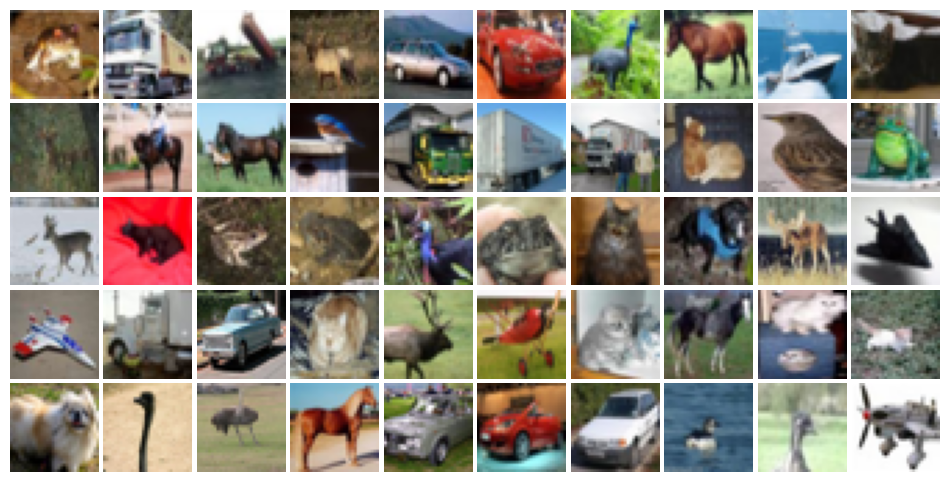

In [48]:
# 画图
plt.figure(figsize=(12, 6))
plt.subplots_adjust(wspace=0.05, hspace=0.05)

for i in range(50):
    plt.subplot(5, 10, i + 1)
    plt.imshow(dst[i][0])
#     plt.title((dir_label[dst[i][1]]))
    plt.axis('off')

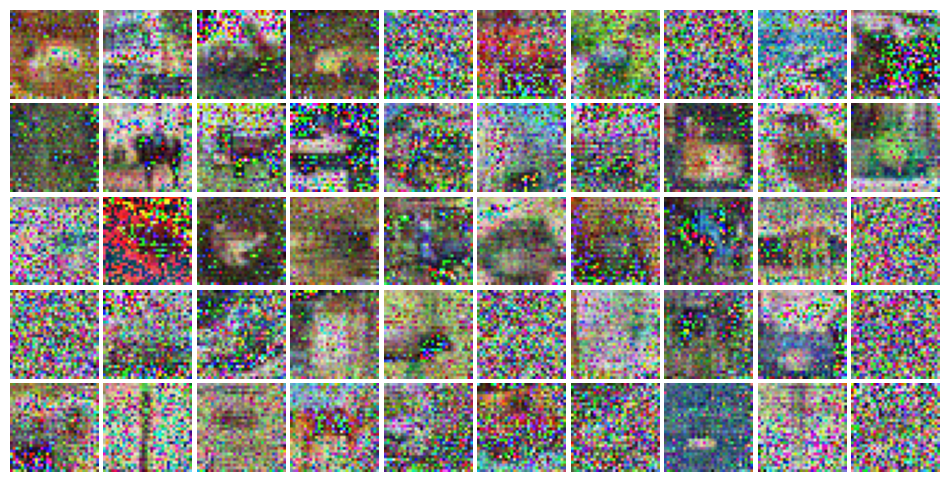

In [57]:
# 画图
plt.figure(figsize=(12, 6))
plt.subplots_adjust(wspace=0.05, hspace=0.05)

for i in range(50):
    plt.subplot(5, 10, i + 1)
    plt.imshow(History[i])
    plt.axis('off')
#     plt.subplot(10, 10, i + 2)
#     plt.imshow(dst[i][0])
# #    plt.title((dir_label[dst[i][1]]))
#     plt.axis('off')

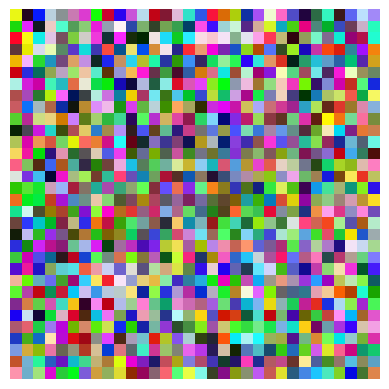

In [81]:
for i in range(50):
#     plt.subplot(5, 10, i + 1)
    plt.imshow(History[i])
    plt.axis('off')
    plt.savefig(f"image_{i}.png",bbox_inches='tight')  # 保存每一张图片，文件名包含索引 i

In [72]:
img_list2=[ i[0] for i in dst]
img_list2=img_list2[:50]

In [73]:
fig, axs = plt.subplots(num_rows, 10, figsize=(12, 8))
plt.subplots_adjust(wspace=0.05, hspace=0.05)
num_rows = len(History) + len(img_list2)

for i, img in enumerate(History + img_list2):
    row, col = divmod(i, num_rows)
    axs[row, col].imshow(img)
    axs[row, col].axis('off')
# 添加整个图的标题
plt.suptitle("My Awesome Image Collection")

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f4fad46dc10> (for post_execute):


KeyboardInterrupt: 

In [ ]:
from skimage.metrics import peak_signal_noise_ratio as psnr
psnr(np.array(dst[img_index][0]), np.array(history[-1]))

# 导入必要的库
from skimage.metrics import structural_similarity as ssim # 使用skimage库中的SSIM函数
import numpy as np # 使用numpy库进行数组操作

# 定义SSIM计算函数
def compare_ssim(img1, img2, maxvalue=255):
    # 将图像转换为浮点数类型
    img1 = np.array(img1).astype(np.float64)
    img2 = np.array(img2).astype(np.float64)
    # 调用skimage库中的SSIM函数，指定数据范围为maxvalue
    return ssim(img1, img2, data_range=maxvalue,win_size=3)

In [ ]:
compare_ssim(dst[img_index][0], history[-1], maxvalue=255)